# Introduction

This notebook discusses the concepts behind boosting kernel density estimates (KDE).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(17)

## Generate data

The data we will use is a mixture of two Gaussians: a more frequent one, "typical", and a less frequent one, "anomaly".

In [2]:
# Set parameters
typical_mean = 0
typical_sd = 1
typical_n = 100000

anomaly_mean = 5
anomaly_sd = 1
anomaly_n = 100

print('ratio anomaly / typical: %.3f%%' % (anomaly_n / typical_n * 100))

# Generate the two distributions
typical_data = np.random.normal(loc=typical_mean, scale=typical_sd, size=(typical_n, ))
anomaly_data = np.random.normal(loc=anomaly_mean, scale=anomaly_sd, size=(anomaly_n, ))
# Concatenate
data = np.hstack((typical_data, anomaly_data)).reshape(-1, 1)

ratio anomaly / typical: 0.100%


## Visualize distributions

In [3]:
# Set bins for the hostogram
data_bins = np.linspace(-5, 12, 100)

# Compute histograms
typical_hist, _ = np.histogram(typical_data, data_bins)
anomaly_hist, _ = np.histogram(anomaly_data, data_bins)
data_hist, _ = np.histogram(data, data_bins)

# Transform count to density
typical_hist = typical_hist / typical_hist.sum()
anomaly_hist = anomaly_hist / anomaly_hist.sum()
data_hist = data_hist / data_hist.sum()

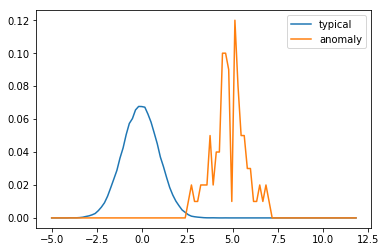

In [4]:
# Plot the 2 distributions
plt.plot(data_bins[:-1], typical_hist, label='typical')
plt.plot(data_bins[:-1], anomaly_hist, label='anomaly')
plt.legend();

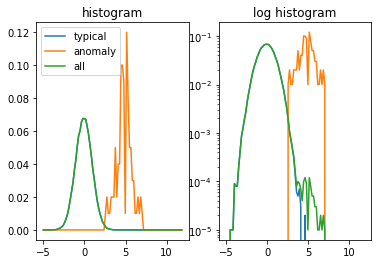

In [5]:
# To show the effect of "anomaly" data points, take the log of the histogram

ax = list()
for i_panel in range(2):
    ax.append(plt.subplot(1, 2, i_panel + 1))
    ax[i_panel].plot(data_bins[:-1], typical_hist, label='typical')
    ax[i_panel].plot(data_bins[:-1], anomaly_hist, label='anomaly')
    ax[i_panel].plot(data_bins[:-1], data_hist, label='all')
    if i_panel == 0:
        ax[i_panel].legend()
        
ax[0].set_title('histogram')
ax[1].set_title('log histogram')
ax[1].set_yscale('log')

# Compute boosted KDE

In [6]:
%%time

from boosted_KDE import KDEBoosting

bKD = KDEBoosting(data, k_iterations=1, n_jobs=-1)

CPU times: user 4min 41s, sys: 2min 25s, total: 7min 7s
Wall time: 9min 9s


## Show results

In [7]:
# Compute weighted histogram
weighted_data_hist, _ = np.histogram(data.ravel(), data_bins, weights=bKD.weights)
original_weighted_data_hist, _ = np.histogram(data.ravel(), data_bins, weights=bKD.normalized_weights)

# Transform count to density
weighted_data_hist = weighted_data_hist / weighted_data_hist.sum()
original_weighted_data_hist = original_weighted_data_hist / original_weighted_data_hist.sum()

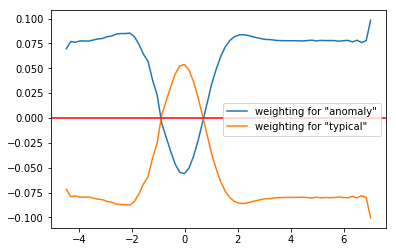

In [8]:
# Show difference in weights
with np.errstate(divide='ignore', invalid='ignore'):
    plt.plot(data_bins[:-1], np.log(weighted_data_hist) - np.log(data_hist), label='weighting for "anomaly"')
    plt.plot(data_bins[:-1], np.log(original_weighted_data_hist) - np.log(data_hist), label='weighting for "typical"')
    plt.axhline(0, color='r')
    plt.legend();

The plot above shows how the use of the weights computed with this algorithm can be used to steer a classifier toward or away less frequent data points.